## Background

In the previous notebooks I finetuned the [TinyStories-33M](https://vishalbakshi.github.io/blog/posts/2024-08-13-tinystories-33m-finetune/), [TinyStories-8M](https://www.kaggle.com/code/vishalbakshi/finetuning-tinystories-8m-on-financial-phrasebank) and [TinyStories-3M](https://www.kaggle.com/code/vishalbakshi/finetuning-tinystories-3m-on-financial-phrasebank/) models on the `financial_phrasebank` dataset and achieved the following results:

|Arch|Fine-tuning Learning Rate|Best Val Acc|Best Test Acc|
|:-:|:-:|:-:|:-:|
|TinyStories-33M|5e-04|86%|79%|
|TinyStories-8M|8e-05|85%|86%|
|TinyStories-8M|5e-04|79%|86%|
|TinyStories-3M|8e-05|78%|74%|

In this notebook, I'll finetune the smallest TinyStories-1M model and see how it performs. I also suspect these models might perform better on a (synthetically generated) simpler version of this dataset, which I plan to explore in a future notebook.

In [ ]:
#| code-fold: true
#| code-summary: "Show imports and setup"
from datasets import load_dataset
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TrainingArguments, Trainer, TrainerCallback
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F

import gc
def report_gpu():
    print(torch.cuda.list_gpu_processes())
    gc.collect()
    torch.cuda.empty_cache()
    
#model_nm = "roneneldan/TinyStories-33M"
model_nm = "roneneldan/TinyStories-1M"
#model_nm = "roneneldan/TinyStories-3M"
#model_nm = "roneneldan/TinyStories-8M"

tokz = AutoTokenizer.from_pretrained(model_nm)
def tok_func(x): return tokz(x["input"], padding=True, truncation=True)

## Preparing Datasets

Much of the code in this section is boilerplate, tokenizing the dataset and splitting it into training, validation and test sets.

In [ ]:
#| code-fold: true
#| code-summary: "Show load_dataset"
dataset = load_dataset(
    "financial_phrasebank", "sentences_allagree",
    split="train"  # note that the dataset does not have a default test split
)

dataset = dataset.rename_columns({'label':'labels', 'sentence': 'input'})

In [ ]:
tokz.add_special_tokens({'pad_token': '[PAD]'})
tokz.padding_side = "left" # https://github.com/huggingface/transformers/issues/16595 and https://www.kaggle.com/code/baekseungyun/gpt-2-with-huggingface-pytorch
tok_ds = dataset.map(tok_func, batched=True)

In [6]:
tok_ds[0]['input']

'According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .'

In [7]:
tok_ds[0]['input_ids'][100:110] # first 100 elements are 50257 ('[PAD]')

[50257, 50257, 50257, 50257, 50257, 50257, 4821, 284, 17113, 837]

In [8]:
tokz.decode(50257), tokz.decode(4821), tokz.decode(284), tokz.decode(17113)

('[PAD]', 'According', ' to', ' Gran')

In [9]:
tok_ds[0]['labels']

1

In [10]:
split_dataset = tok_ds.train_test_split(test_size=225/2264, seed=42)

training_split = split_dataset['train'].train_test_split(test_size=0.2, seed=42)

train_ds = training_split['train']
eval_ds = training_split['test']
test_ds = split_dataset['test']

train_ds, eval_ds, test_ds

(Dataset({
     features: ['input', 'labels', 'input_ids', 'attention_mask'],
     num_rows: 1631
 }),
 Dataset({
     features: ['input', 'labels', 'input_ids', 'attention_mask'],
     num_rows: 408
 }),
 Dataset({
     features: ['input', 'labels', 'input_ids', 'attention_mask'],
     num_rows: 225
 }))

In [11]:
train_ds[0]['input']

'The result will also be burdened by increased fixed costs associated with operations in China , and restructuring costs in Japan .'

In [12]:
train_ds[0]['labels']

0

The dataset distributions show a predominance of `neutral` (`1`) sentences:

In [13]:
train_ds.to_pandas()['labels'].value_counts() / len(train_ds)

labels
1    0.622318
2    0.251993
0    0.125690
Name: count, dtype: float64

In [14]:
eval_ds.to_pandas()['labels'].value_counts() / len(eval_ds)

labels
1    0.615196
2    0.257353
0    0.127451
Name: count, dtype: float64

In [15]:
test_ds.to_pandas()['labels'].value_counts() / len(test_ds)

labels
1    0.555556
2    0.240000
0    0.204444
Name: count, dtype: float64

## Prepare for Training

Much of the code in this section is either helper functions (like `get_acc`, `MetricCallback`, or `results_to_dataframe`) or boilerplate code to prepare a HuggingFace trainer:

In [16]:
#| code-fold: true
#| code-summary: "Show `get_acc` function"
def get_acc(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {"accuracy": (predictions == labels).astype(np.float32).mean().item()}

In [17]:
#| code-fold: true
#| code-summary: "Show `MetricCallback` function"
# thanks Claude

class MetricCallback(TrainerCallback):
    def __init__(self):
        self.metrics = []
        self.current_epoch_metrics = {}

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            self.current_epoch_metrics.update(logs)

    def on_epoch_end(self, args, state, control, **kwargs):
        if hasattr(state, 'log_history') and state.log_history:
            # Get the last logged learning rate
            last_lr = state.log_history[-1].get('learning_rate', None)
        else:
            last_lr = None

        self.metrics.append({
            "epoch": state.epoch,
            "learning_rate": last_lr,
            **self.current_epoch_metrics
        })
        self.current_epoch_metrics = {}  # Reset for next epoch

    def on_train_end(self, args, state, control, **kwargs):
        # Capture final metrics after the last epoch
        if self.current_epoch_metrics:
            self.metrics.append({
                "epoch": state.num_train_epochs,
                "learning_rate": self.metrics[-1].get('learning_rate') if self.metrics else None,
                **self.current_epoch_metrics
            })

In [18]:
#| code-fold: true
#| code-summary: "Show `results_to_dataframe` function"
def results_to_dataframe(results, model_name):
    rows = []
    for result in results:
        initial_lr = result['learning_rate']
        for metric in result['metrics']:
            row = {
                'model_name': model_name,
                'initial_learning_rate': initial_lr,
                'current_learning_rate': metric.get('learning_rate'),
            }
            row.update(metric)
            rows.append(row)
    
    df = pd.DataFrame(rows)
    
    # Ensure specific columns are at the beginning
    first_columns = ['model_name', 'initial_learning_rate', 'current_learning_rate', 'epoch']
    other_columns = [col for col in df.columns if col not in first_columns]
    df = df[first_columns + other_columns]
    
    return df

In [19]:
#| code-fold: true
#| code-summary: "Show `make_cm` function"
def make_cm(df):
    """Create confusion matrix for true vs predicted sentiment classes"""
    
    cm = confusion_matrix(y_true=df['label_text'], y_pred=df['pred_text'], labels=['negative', 'neutral', 'positive'])
    disp = ConfusionMatrixDisplay(cm, display_labels=['negative', 'neutral', 'positive'])
    
    fig, ax = plt.subplots(figsize=(4,4))
    disp.plot(ax=ax,text_kw={'fontsize': 12}, cmap='Blues', colorbar=False);
    
    # change label font size without changing label text
    ax.xaxis.label.set_fontsize(16)
    ax.yaxis.label.set_fontsize(16)
    
    # make tick labels larger
    ax.tick_params(axis='y', labelsize=14)
    ax.tick_params(axis='x', labelsize=14)

In [20]:
#| code-fold: true
#| code-summary: "Show `get_prediction` function"
def get_prediction(model, text, tokz):
    # Determine the device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Move the model to the appropriate device
    model = model.to(device)

    # Tokenize the input text
    inputs = tokz(text, return_tensors="pt", truncation=True, padding=True)

    # Move input tensors to the same device as the model
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Get the model's prediction
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        outputs = model(**inputs)

    # Ensure logits are on CPU for numpy operations
    logits = outputs.logits.detach().cpu()

    # Get probabilities
    probs = torch.softmax(logits, dim=-1)

    # Get the predicted class
    p_class = torch.argmax(probs, dim=-1).item()

    # Get the probability for the predicted class
    p = probs[0][p_class].item()

    labels = {0: "negative", 1: "neutral", 2: "positive"}
    
    print(f"Probability: {p:.2f}")
    print(f"Predicted label: {labels[p_class]}")
    return p_class, p

In [21]:
#| code-fold: true
#| code-summary: "Show `get_trainer` function"
def get_trainer(lr, bs=16):

    args = TrainingArguments(
        'outputs',
        learning_rate=lr,
        warmup_ratio=0.1,
        lr_scheduler_type='cosine',
        fp16=True,
        eval_strategy="epoch",
        logging_strategy="epoch",
        per_device_train_batch_size=bs,
        per_device_eval_batch_size=bs*2,
        num_train_epochs=3,
        weight_decay=0.01,
        report_to='none')
    
    model = AutoModelForSequenceClassification.from_pretrained(model_nm, num_labels=3) # 3 labels for 3 classes
    model.resize_token_embeddings(len(tokz))
    model.config.pad_token_id = model.config.eos_token_id
    
    trainer = Trainer(model, args, train_dataset=train_ds, eval_dataset=eval_ds, 
                  tokenizer=tokz, compute_metrics=get_acc, callbacks=[metric_callback])
    
    return trainer, args

In [22]:
#| code-fold: true
#| code-summary: "Show `get_test_df` function"
def get_test_df(trainer):
    test_df = test_ds.to_pandas()[['input', 'labels']]
    
    preds = trainer.predict(test_ds).predictions.astype(float)
    probs = F.softmax(torch.tensor(preds), dim=1)
    predicted_classes = torch.argmax(probs, dim=1).numpy()

    test_df['predicted'] = predicted_classes
    
    test_df['match'] = test_df['labels'] == test_df['predicted']
    acc = test_df['match'].mean()
    
    label_map = {i: label_text for i, label_text in enumerate(test_ds.features["labels"].names)}
    test_df['label_text'] = test_df['labels'].apply(lambda x: label_map[x])
    test_df['pred_text'] = test_df['predicted'].apply(lambda x: label_map[x])
    
    return test_df, acc

## Training: Learning Rate Sweep

While there are other hyperparameters to tune (`epochs`, `warmup_ratio`, `weight_decay`) I'll focus this notebook on fine-tuning with different learning rates. I'll start with the same learning rates that I used for the 33M, 8M and 3M models:

In [ ]:
#| code-fold: true
#| code-summary: "Show training loop"
metrics = []
trainers = []
learning_rates = [1e-6, 1e-5, 3e-5, 5e-5, 8e-5, 1e-4, 3e-4, 5e-4, 8e-4, 1e-3, 1e-2, 1e-1]

for lr in learning_rates:
    print(f"Learning Rate: {lr}")
    
    metric_callback = MetricCallback()
    
    trainer, args = get_trainer(lr, bs=64)

    trainer.train()

    metrics.append({
        "learning_rate": lr,
        "metrics": metric_callback.metrics
        })
    
    trainers.append(trainer) 
    
    # clean up
    report_gpu()
    !rm -r /kaggle/working/outputs

In [24]:
metrics_df = results_to_dataframe(metrics, model_name=model_nm)
metrics_df = metrics_df.query('current_learning_rate.notna()')

## Results

### Highest Validation Set Accuracy

The highest validation set accuracy (75%) was obtained with two learning rates: `0.0001` and `0.0003`. Both are an order of magnitude larger than the best performing learning rates for the 33M, 8M and 3M models.

In [26]:
metrics_df.query('eval_accuracy == eval_accuracy.max()')

,model_name,initial_learning_rate,current_learning_rate,epoch,learning_rate,loss,grad_norm,eval_loss,eval_accuracy,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
23,roneneldan/TinyStories-1M,0.0001,0.0,3.0,0.0,0.5583,814660.5625,0.595688,0.747549,0.2664,1531.612,7.508,7.0189,697.118,5.556,1.533190e+12,0.723877
27,roneneldan/TinyStories-1M,0.0003,0.0,3.0,0.0,0.5974,330743.3750,0.627727,0.747549,0.2700,1510.882,7.406,6.9875,700.250,5.581,1.533190e+12,0.748295


In [31]:
learning_rates[5], learning_rates[6]

(0.0001, 0.0003)

An LR of `0.0001` has a slightly higher test set accuracy (65%) than `0.0003` (64%).

In [32]:
test_df, acc = get_test_df(trainers[5])
acc

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


0.6488888888888888

In [33]:
test_df, acc = get_test_df(trainers[6])
acc

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


0.64

This 8M parameter finetuned model predicts `neutral` sentences the best (112/125) followed by `negative` sentences (36/46) and lastly, `positive` sentences (31/54). This bucks the trend of the other three models (`neutral` > `positive` > `negative`, which followed the proportion of each sentiment in the dataset).

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


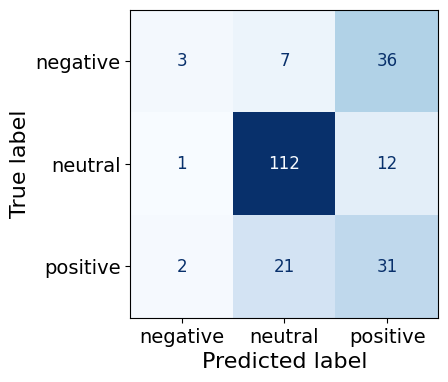

In [35]:
test_df, acc = get_test_df(trainers[5])
make_cm(test_df)

As the learning rate increases (starting at 1e-6) the validation set accuracy increases until it reaches a bit of plateau at 10-4 before coming down.

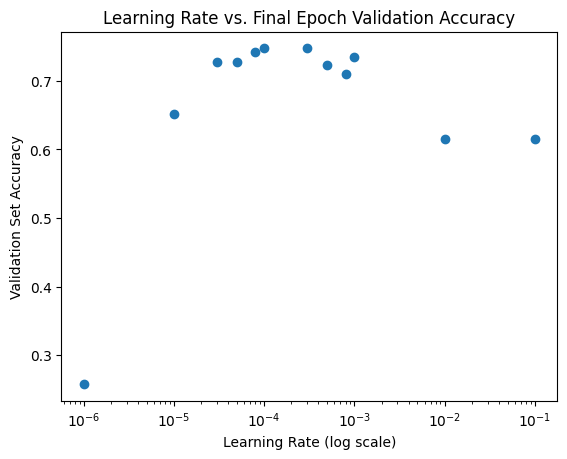

In [36]:
#| code-fold: true
#| code-summary: "Show plotting code"
final_epoch_metrics = metrics_df.query("epoch == 3")
plt.scatter(final_epoch_metrics['initial_learning_rate'], final_epoch_metrics['eval_accuracy']);
plt.xscale('log')
plt.xlabel('Learning Rate (log scale)')
plt.ylabel('Validation Set Accuracy')
plt.title('Learning Rate vs. Final Epoch Validation Accuracy');

I'll test the model (run a "sanity check") on three made-up sentences. I don't want to weigh these results too much as they are cherry-picked sentences, but this model only gets one of them right (`neutral`).

In [37]:
text = "The net sales went up from USD $3.4M to USD $5.6M since the same quarter last year"

_ = get_prediction(trainers[5].model, text, tokz)

Probability: 0.50
Predicted label: negative


In [38]:
text = "The net sales went down from USD $8.9M to USD $1.2M since the same quarter last year"

_ = get_prediction(trainers[5].model, text, tokz)

Probability: 0.51
Predicted label: positive


In [39]:
text = "The net sales stayed the as the same quarter last year"

_ = get_prediction(trainers[5].model, text, tokz)

Probability: 0.50
Predicted label: neutral


### Highest Test Set Accuracy

In [ ]:
test_dfs = []
accs = []
for t in trainers:
    test_df, acc = get_test_df(t)
    test_dfs.append(test_df)
    accs.append(acc)

The learning rate with the highest test set accuracy (68%) is `0.001`. This is by far the largest best-performing learning rate across the 33M, 8M, 3M and now 1M parameter TinyStories models.

In [41]:
accs

[0.2311111111111111,
 0.6,
 0.6444444444444445,
 0.6711111111111111,
 0.6622222222222223,
 0.6488888888888888,
 0.64,
 0.6444444444444445,
 0.6355555555555555,
 0.6755555555555556,
 0.5555555555555556,
 0.5555555555555556]

In [44]:
accs[9], learning_rates[9]

(0.6755555555555556, 0.001)

This learning rate had a validation set accuracy of about 74%.

In [45]:
final_epoch_metrics.query("initial_learning_rate == 0.001")

,model_name,initial_learning_rate,current_learning_rate,epoch,learning_rate,loss,grad_norm,eval_loss,eval_accuracy,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
39,roneneldan/TinyStories-1M,0.001,0.0,3.0,0.0,0.5895,191542.265625,0.622454,0.735294,0.2941,1387.377,6.801,7.0237,696.642,5.553,1.533190e+12,0.761687


This model gets 181/125 `neutral` predictions correct, followed by 33/46 `negative` predictions and 33/54 `positive` predictions, continuing the trend for 1M models that deviates from the previous three sizes.

(0.6755555555555556, 0.001, None)

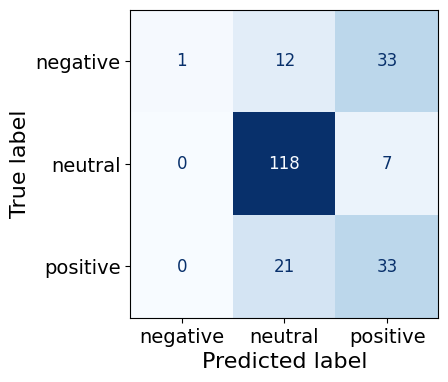

In [47]:
accs[9], learning_rates[9], make_cm(test_dfs[9])

This model gets 2/3 of the sanity check sentiments correct.

In [48]:
text = "The net sales went up from USD $3.4M to USD $5.6M since the same quarter last year"

_ = get_prediction(trainers[9].model, text, tokz)

Probability: 0.42
Predicted label: positive


In [49]:
text = "The net sales went down from USD $8.9M to USD $1.2M since the same quarter last year"

_ = get_prediction(trainers[9].model, text, tokz)

Probability: 0.51
Predicted label: positive


In [50]:
text = "The net sales stayed the as the same quarter last year"

_ = get_prediction(trainers[9].model, text, tokz)

Probability: 0.96
Predicted label: neutral


## Training with the Best Learning Rates 10 Times

Since I have different models achieving the highest validation set accuracy and the highest test set accuracy, I'll train 10 models for each learning rate to see if the results are consistent.

### LR = 0.0001 (Highest Validation Set Accuracy)

In [51]:
learning_rates[5]

0.0001

To prevent (all but the first) models from getting the same loss and accuracy per epoch, I'll reset the random seed each iteration.

In [52]:
#| code-fold: true
#| code-summary: "Show `set_seed` function"
import random
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

In [ ]:
#| code-fold: true
#| code-summary: "Show training loop"
best_metrics = []
best_trainers = []
lr = learning_rates[5]

for i in range(10):
    set_seed(42 + i)  # Use a different seed for each run
    metric_callback = MetricCallback()
    trainer, args = get_trainer(lr=lr, bs=64)
    trainer.train()

    best_metrics.append({
        "learning_rate": lr,
        "metrics": metric_callback.metrics
        })
    
    best_trainers.append(trainer) 
    
    # clean up
    report_gpu()
    !rm -r /kaggle/working/outputs

In [54]:
best_metrics_df = results_to_dataframe(best_metrics, model_name=model_nm)
best_metrics_df = best_metrics_df.query('current_learning_rate.notna()')
best_metrics_df.head(3)

,model_name,initial_learning_rate,current_learning_rate,epoch,learning_rate,loss,grad_norm,eval_loss,eval_accuracy,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
1,roneneldan/TinyStories-1M,0.0001,0.000085,1.0,0.000085,0.9066,392222.90625,0.815697,0.632353,0.2688,1518.079,7.442,NaN,NaN,NaN,NaN,NaN
2,roneneldan/TinyStories-1M,0.0001,0.000030,2.0,0.000030,0.7411,875535.87500,0.699083,0.710784,0.2755,1481.051,7.260,NaN,NaN,NaN,NaN,NaN
3,roneneldan/TinyStories-1M,0.0001,0.000000,3.0,0.000000,0.6591,501946.84375,0.690590,0.708333,0.2775,1470.421,7.208,7.022,696.805,5.554,1.533190e+12,0.768915


There's a difference of about 5% between the minimum and maximum validation set accuracy for this model.

In [55]:
final_accs = best_metrics_df.query("epoch == 3")['eval_accuracy']
final_accs.describe()

count    10.000000
mean      0.723039
std       0.016703
min       0.698529
25%       0.711397
50%       0.725490
75%       0.734681
max       0.745098
Name: eval_accuracy, dtype: float64

In [ ]:
test_dfs = []
accs = []
for t in best_trainers:
    test_df, acc = get_test_df(t)
    test_dfs.append(test_df)
    accs.append(acc)

There's a difference of about 5% between the min and max test set accuracy as well.

In [58]:
accs = pd.Series(accs)
accs.describe()

count    10.000000
mean      0.664000
std       0.018995
min       0.631111
25%       0.648889
50%       0.666667
75%       0.678889
max       0.688889
dtype: float64

In [59]:
accs

0    0.631111
1    0.671111
2    0.648889
3    0.684444
4    0.648889
5    0.648889
6    0.680000
7    0.688889
8    0.675556
9    0.662222
dtype: float64

The best performing model (for test set accuracy, 69%) gets 2/3 of my sanity check sentiments correct.

In [60]:
text = "The net sales went up from USD $3.4M to USD $5.6M since the same quarter last year"

_ = get_prediction(best_trainers[7].model, text, tokz)

Probability: 0.55
Predicted label: positive


In [61]:
text = "The net sales went down from USD $8.9M to USD $1.2M since the same quarter last year"

_ = get_prediction(best_trainers[7].model, text, tokz)

Probability: 0.56
Predicted label: positive


In [62]:
text = "The net sales stayed the as the same quarter last year"

_ = get_prediction(best_trainers[7].model, text, tokz)

Probability: 0.60
Predicted label: neutral


### LR = 0.001 (Highest Test Set Accuracy)

In [63]:
learning_rates[9] == 0.001

True

In [ ]:
#| code-fold: true
#| code-summary: "Show training loop"
best_metrics2 = []
best_trainers2 = []
lr = learning_rates[9]

for i in range(10):
    set_seed(42 + i)  # Use a different seed for each run
    metric_callback = MetricCallback()
    trainer, args = get_trainer(lr=lr, bs=64)
    trainer.train()

    best_metrics2.append({
        "learning_rate": lr,
        "metrics": metric_callback.metrics
        })
    
    best_trainers2.append(trainer) 
    
    # clean up
    report_gpu()
    !rm -r /kaggle/working/outputs

In [65]:
best_metrics_df2 = results_to_dataframe(best_metrics2, model_name=model_nm)
best_metrics_df2 = best_metrics_df2.query('current_learning_rate.notna()')
best_metrics_df2.head(3)

,model_name,initial_learning_rate,current_learning_rate,epoch,learning_rate,loss,grad_norm,eval_loss,eval_accuracy,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
1,roneneldan/TinyStories-1M,0.001,0.000846,1.0,0.000846,0.9313,470919.59375,0.809184,0.627451,0.2713,1504.052,7.373,NaN,NaN,NaN,NaN,NaN
2,roneneldan/TinyStories-1M,0.001,0.000303,2.0,0.000303,0.7477,462428.84375,0.732228,0.681373,0.2745,1486.436,7.286,NaN,NaN,NaN,NaN,NaN
3,roneneldan/TinyStories-1M,0.001,0.000000,3.0,0.000000,0.6664,186014.03125,0.699403,0.708333,0.2889,1412.300,6.923,7.1325,686.011,5.468,1.533190e+12,0.781793


The maximum validation set accuracy for this learning rate is about 74%.

In [66]:
final_accs2 = best_metrics_df2.query("epoch == 3")['eval_accuracy']
final_accs2.describe()

count    10.000000
mean      0.714706
std       0.018129
min       0.678922
25%       0.710172
50%       0.719363
75%       0.726716
max       0.735294
Name: eval_accuracy, dtype: float64

In [ ]:
test_dfs2 = []
accs2 = []
for t in best_trainers2:
    test_df, acc = get_test_df(t)
    test_dfs2.append(test_df)
    accs2.append(acc)

The largest test set accuracy was 68%.

In [73]:
accs2 = pd.Series(accs2)
accs2.describe()

count    10.000000
mean      0.651556
std       0.021284
min       0.613333
25%       0.640000
50%       0.651111
75%       0.672222
max       0.675556
dtype: float64

In [74]:
accs2

0    0.662222
1    0.675556
2    0.640000
3    0.675556
4    0.613333
5    0.640000
6    0.631111
7    0.657778
8    0.675556
9    0.644444
dtype: float64

The 8th model (both the 3rd and 8th model have a test set accuracy of 68%) goes 2/3 in my sanity checks.

In [81]:
text = "The net sales went up from USD $3.4M to USD $5.6M since the same quarter last year"

_ = get_prediction(best_trainers2[8].model, text, tokz)

Probability: 0.57
Predicted label: positive


In [82]:
text = "The net sales went down from USD $8.9M to USD $1.2M since the same quarter last year"

_ = get_prediction(best_trainers2[8].model, text, tokz)

Probability: 0.56
Predicted label: positive


In [83]:
text = "The net sales stayed the as the same quarter last year"

_ = get_prediction(best_trainers2[8].model, text, tokz)

Probability: 0.72
Predicted label: neutral


## Final Thoughts

This notebook closes out my initial quick-and-dirty model fine-tuning experiments for the TinyStories family (33M, 8M, 3M, 1M) on the `financial_phrasebank` dataset. Here is a summary of my results:

|Base Model|Fine-tuning Learning Rate|Best Val Acc|Best Test Acc|
|:-:|:-:|:-:|:-:|
|TinyStories-33M|5e-04|86%|79%|
|TinyStories-8M|8e-05|85%|86%|
|TinyStories-8M|5e-04|79%|86%|
|TinyStories-3M|8e-05|78%|74%|
|TinyStories-1M|1e-04|75%|69%|
|TinyStories-1M|1e-03|74%|68%|



Three main takeaways:

- Set the random seed for each iteration to avoid getting the same accuracy and loss values in a for-loop
- The 8M model had a 7% higher test set accuracy than the 33M model.
- The best performing learning rates for the smallest model, 1M, were 1-2 orders of magnitude smaller than the best performing learning rates for the 33M, 8M and 3M models.

Future work:

- Refactor this code to avoid changing so many variables.
- Do a more thorough hyperparameter sweep (random seeds, epochs, warmup, weight decay, learning rates) for each model.
- Fine-tune the models on a synthetically generated version of `financial_phrasebank` that's at a lower reading level to see if it improves performance.


I hope you enjoyed this blog post! Follow me on Twitter [@vishal_learner](https://twitter.com/vishal_leaner).